In [1]:
# external imports, for plotting
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

/home/bzfschwa/conda/envs/mathprogvis/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# import of relevant modules from mathprogvis
import mathprogvis
from mathprogvis import poly
from mathprogvis import mccormick
from mathprogvis import balas

In [3]:
%matplotlib inline

In [4]:
sns.set_context('talk')

In [5]:
# add common variable names, and 'b' for the constant term (rhs)
x, y, z, b = 'x,y,z,'.split(',')

## Test: $z = |x|$ using sign indicator $y$

We compare different approaches and relaxations for the (non-convex) constraint of the absolute value function.

For effect, we choose non-symmetric variable bounds for the variable $x$ of which the absolute value is chosen. From these bounds of $x$, bounds on $z$ are implied.

In [6]:
xlb, xub = -2, 3
zlb, zub =  0, max(-xlb, xub)

We model the absolute value by the equation $z = x(2y - 1)$ with an auxiliary variable $y \in \{0, 1\}$.

The function `mccormick.sparse_ineqs` takes as input three expressions, for $x$, $y$ and $z$ in $z = x y$. Each expression is given in a sparse format based on a dictionary that maps variable names to coefficients. Constant terms are represented by the empty string as key.

Further, a list of variable names is given (e.g., ['x', 'y', 'z']) and finally, lists of lower and upper bounds for all these variables.

The function then computes the inequalities of the McCormick relaxation of the expression, with respect to the given variables and bounds. The result is a list of inequalities in the same sparse format, understood as $a^t x + b \ge 0$.

In [7]:
ylb, yub = 0, 1

In [8]:
mc = mccormick.sparse_ineqs({x:1}, {y:2, b:-1}, {z:1}, [x, y, z], [xlb, ylb, zlb], [xub, yub, zub])
print(mc)

[{'z': 1.0, 'x': 1.0, 'y': 4.0}, {'': 6.0, 'z': 1.0, 'x': -1.0, 'y': -6.0}, {'': 4.0, 'z': -1.0, 'x': 1.0, 'y': -4.0}, {'z': -1.0, 'x': -1.0, 'y': 6.0}]


In [9]:
# we sample uniform grid points in the bounds to prepare plotting
xx = np.linspace(xlb, xub)
yy = np.linspace(ylb, yub)
xx, yy = np.meshgrid(xx, yy)

zz = xx*(2*yy - 1)

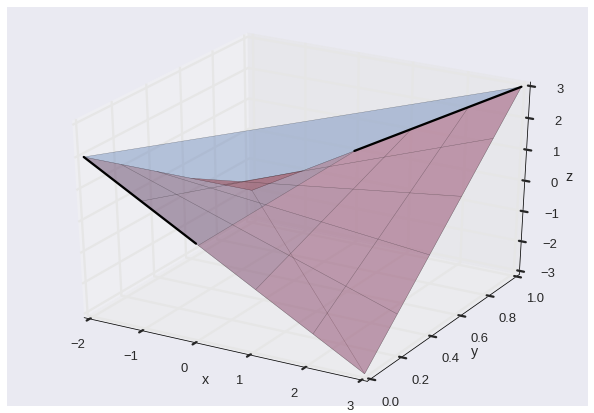

In [10]:
# compute the vertices of the McCormick relaxation
v = poly.sparse2verts(mc, [x, y, z])

# plot the convex hull of the vertices (= the McCormick relaxation) (blue)
fig, ax = poly.plot3d(poly.polygon3D(v));

# plot the actual (continuous) feasible region of z = x*(2*y - 1) (red)
ax.plot_surface(xx, yy, zz, color='r', alpha=0.2)

# plot the two branches of the disjunction for z = abs(x) (black)
ax.plot([0, xlb], [0, 0], [0, abs(xlb)], color='black')
ax.plot([0, xub], [1, 1], [0, abs(xub)], color='black')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

As can be seen, the blue tetrahedron is indeed the convex hull of the red surface. It is also tight on the boundary, e.g., for $y \in \{0, 1\}$.

Moreover, we know that $z$ is always non-negative, but the bounds of $z$ are not taken into account by the McCormick relaxation. Neither are other inequalities constraining $x$ and $y$. As a result, the surface on the complete box of bounds must be considered in the convex hull (especially the "negative" corners).

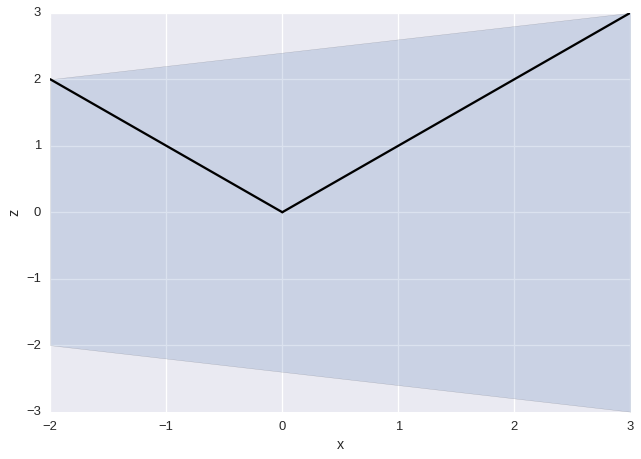

In [11]:
# plot the 2D projection of the McCormick relaxation on the (x,z) space
fig, ax = poly.plot2d(poly.polygon2D(poly.proj_sparse2verts(mc, [x, y, z], [x, z])))

# plot the actual graph of z = abs(x)
ax.plot([0, xlb], [0, abs(xlb)], color='black')
ax.plot([0, xub], [0, abs(xub)], color='black')

ax.set_xlabel('x')
ax.set_ylabel('z');

In the above projection, we can see that the McCormick relaxation does not give a tight hull around the feasible (non-convex) region.

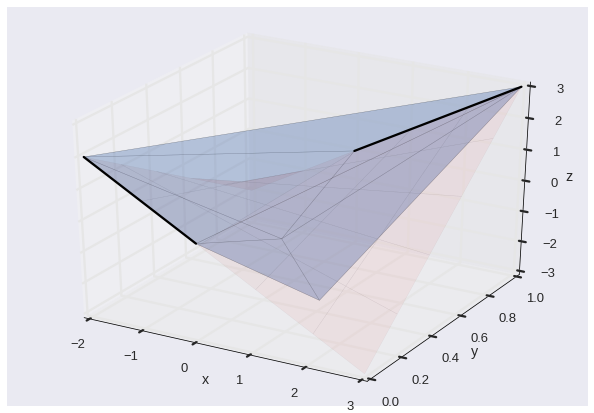

In [12]:
# We can strengthen the formulation by adding further big-M constraints.
# These couple the indicator y with (the bounds/sign of) x.

# x <= xu*y       y == 0  -->  x <= 0
# x >= xl*(1-y)   y == 1  -->  x >= 0
varbounds = [{x:-1, y:xub}, {x:1, y:xlb, b:-xlb}]

# compute again the vertices of the polytope, with the added constraints
v = poly.sparse2verts(mc + varbounds, [x, y, z])

# and plot their convex hull (LP relaxation) (blue)
fig, ax = poly.plot3d(poly.polygon3D(v));

# plot again the surface z = x * (2*y - 1)
ax.plot_surface(xx, yy, zz, color='r', alpha=0.05)

# and the disjunction's branches
ax.plot([0, xlb], [0, 0], [0, abs(xlb)], color='black')
ax.plot([0, xub], [1, 1], [0, abs(xub)], color='black')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

It can be seen that the polytope still contains the black lines but no longer extends fully to the (infeasible) negative corners of the surface. That is, it is still a valid relaxation, stronger than before, but still not quite tight.

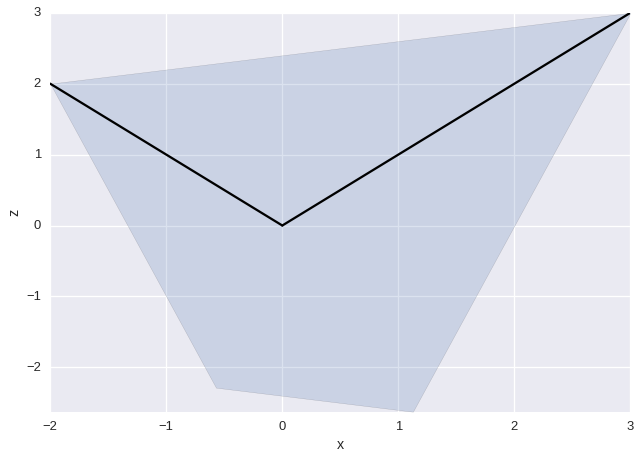

In [13]:
# Compute the 2D projection of the above polytope on (x,z) space
fig, ax = poly.plot2d(poly.polygon2D(poly.proj_sparse2verts(mc + varbounds, [x, y, z], [x, z])))

# add feasible region
ax.plot([0, xlb], [0, abs(xlb)], color='black')
ax.plot([0, xub], [0, abs(xub)], color='black')

ax.set_xlabel('x')
ax.set_ylabel('z');

In the projection, we can also see that the new polytope is valid, tighter, but not the convex hull.

The absolute value function can also be modeled in another, equivalent way, by putting the sign factor on the other side: $z(2y - 1) = x$.

Let us repeat the above steps for this formulation and compare the resulting polytopes.

In [14]:
# In effect, x and z are swapped in the expressions, but keep their bounds.
mc2 = mccormick.sparse_ineqs({z:1}, {y:2, b:-1}, {x:1}, [x, y, z], [xlb, ylb, zlb], [xub, yub, zub])
print(mc2)

[{'z': 1.0, 'x': 1.0}, {'': 6.0, 'z': -1.0, 'y': -6.0, 'x': 1.0}, {'z': 1.0, 'x': -1.0}, {'z': -1.0, 'y': 6.0, 'x': -1.0}]


In [15]:
# add again the big-M constraints for strengthening:
# z <= xub + (zub-xub)*(1-y)     y == 0  -->  z <=  xub
# z <= |xlb| + (zub-|xlb|)*y     y == 1  -->  z <= |xlb|
vb2 = [{z:-1, b:zub, y:xub-zub}, {z:-1, b:abs(xlb), y:zub-abs(xlb)}]

In [16]:
# recreate grid points, now in (y,z) space
zz2 = np.linspace(zlb, zub)
yy2 = np.linspace(ylb, yub)
zz2, yy2 = np.meshgrid(zz2, yy2)
xx2 = zz2*(2*yy2 - 1)

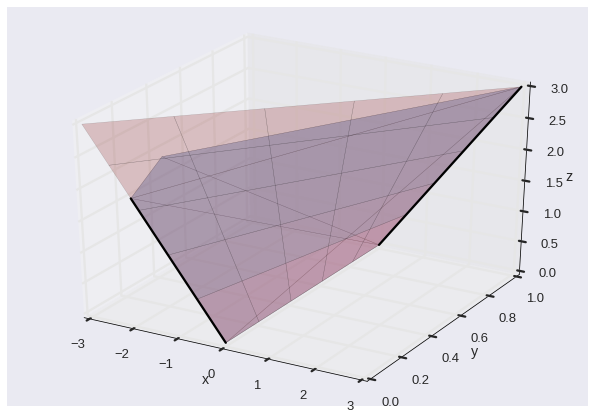

In [17]:
# compute vertices of polyhedron
v2 = poly.sparse2verts(mc2 + vb2, [x, y, z])

# plot convex hull
fig, ax = poly.plot3d(poly.polygon3D(v2));

# plot continuous surface
ax.plot_surface(xx2, yy2, zz2, color='r', alpha=0.2)

# plot actual disjunction's branches
ax.plot([0, xlb], [0, 0], [0, abs(xlb)], color='black')
ax.plot([0, xub], [1, 1], [0, abs(xub)], color='black')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

The surface looks different with this formulation, and the McCormick relaxation follows accordingly. In particular, the "negative corners" are absent. In fact, if the bounds of $x$ were symmetric around 0, the McCormick relaxation would be exact, in this case.

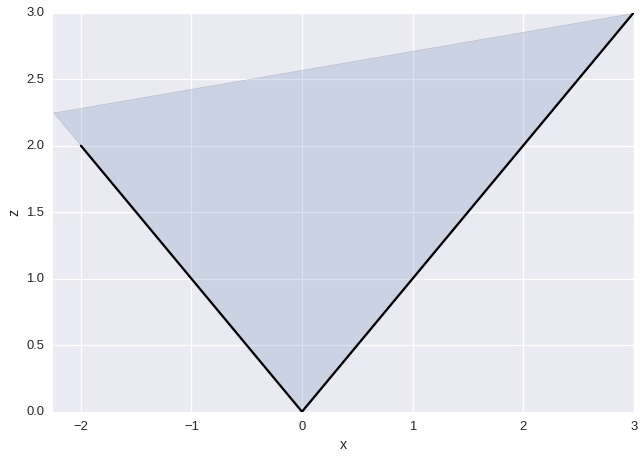

In [18]:
# plot the 2D projection on (x,z) space of the above polytope
fig, ax = poly.plot2d(poly.polygon2D(poly.proj_sparse2verts(mc2 + vb2, [x, y, z], [x, z])))

ax.plot([0, xlb], [0, abs(xlb)], color='black')
ax.plot([0, xub], [0, abs(xub)], color='black')
ax.set_xlabel('x')
ax.set_ylabel('z');

Almost perfect, but not quite!

## Intersection of both

Here we add the constraints from both formulations together

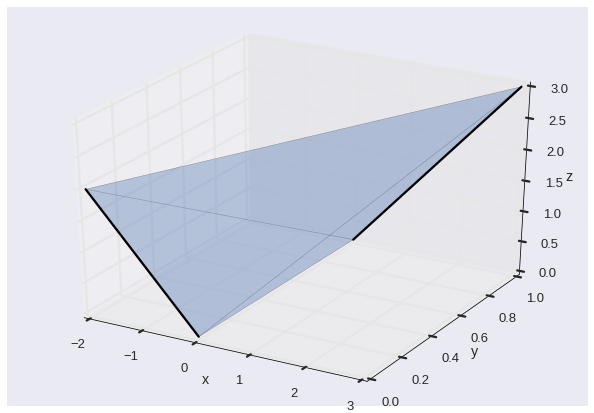

In [19]:
# concatenate all the constraints
inter = mc + varbounds + mc2 + vb2

# compute the vertices
vi = poly.sparse2verts(inter, [x, y, z])

# plot the hull
fig, ax = poly.plot3d(poly.polygon3D(vi));

# plot the actual disjunction's branches
ax.plot([0, xlb], [0, 0], [0, abs(xlb)], color='black')
ax.plot([0, xub], [1, 1], [0, abs(xub)], color='black')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

Finally, we get the convex hull. Is this always the case (for all possible bounds?)

## Balas' model for union of convex sets

We now turn to general approach to model disjunctions of LPs, as proposed by Egon Balas. It is an extended formulation, using copies of the variables (for each branch) and binary indicator variables. The formulation is strong in the sense that the projection of the LP relaxation (on the original variables) gives the convex hull of the feasible regions. 

In [20]:
# Describe the disjunction as nested lists of constraints
ineqss = [[{x:1, z:-1}, {x:-1, z: 1}, {x:1}, {x:-1, b:xub}],
          [{x:1, z: 1}, {x:-1, z:-1}, {x:1, b:-xlb}, {x:-1}]]

# Compute Balas' formulation, by giving the constraints, variable names and the prefix for the indicators.
# The function returns the constraints of the formulation, as well as the variable names of the indicators and copies.
ineqs, inds, copies = balas.disj(ineqss, [x,z], 'y')
print(ineqs)
print(inds)
print(copies)

[{'': -1, 'y#1': 1, 'y#0': 1}, {'': 1, 'y#1': -1, 'y#0': -1}, {'y#0': 1}, {'y#1': 1}, {'x#1': 1, 'x#0': 1, 'x': -1}, {'x#1': -1, 'x#0': -1, 'x': 1}, {'z': -1, 'z#1': 1, 'z#0': 1}, {'z': 1, 'z#1': -1, 'z#0': -1}, {'x#0': 1, 'z#0': -1}, {'x#0': -1, 'z#0': 1}, {'x#0': 1}, {'x#0': -1, 'y#0': 3}, {'x#1': 1, 'z#1': 1}, {'x#1': -1, 'z#1': -1}, {'x#1': 1, 'y#1': 2}, {'x#1': -1}]
['y#0', 'y#1']
['x#0', 'x#1', 'z#0', 'z#1']


[[-2.  2.]
 [ 0.  0.]
 [ 3.  3.]]


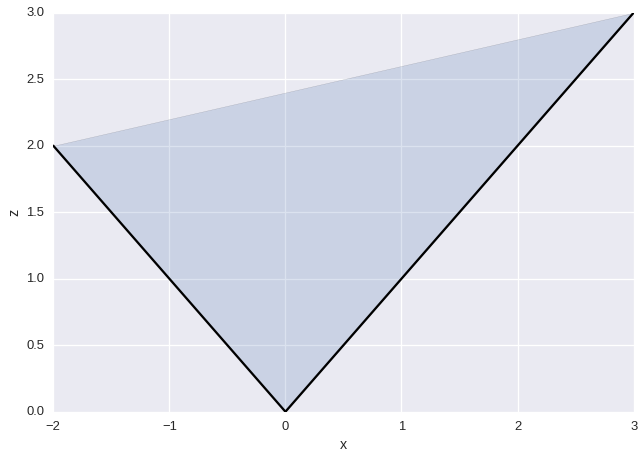

In [21]:
# compute the vertices of the projecton on (x,z) space
v = poly.proj_sparse2verts(ineqs, [x, z] + inds + copies, [x, z])
print(v)

# plot the convex hull
fig, ax = poly.plot2d(poly.polygon2D(v))

# plot the actual feasible region
ax.plot([0, xlb], [0, abs(xlb)], color='black')
ax.plot([0, xub], [0, abs(xub)], color='black')

ax.set_xlabel('x')
ax.set_ylabel('z');

As the theory says, we get the convex hull.

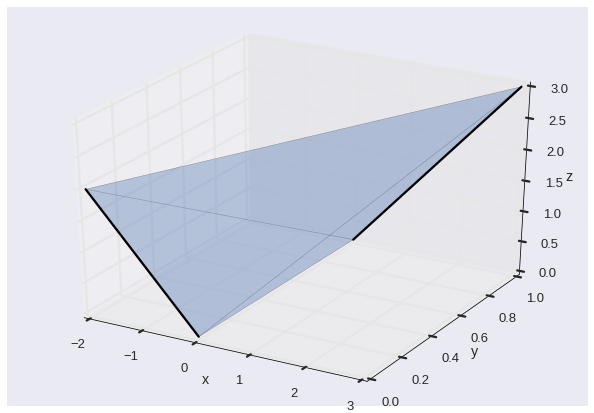

In [22]:
# Recreate the 3D plots from above for comparison.
# Use the indicator for the first branch for y.

v = poly.proj_sparse2verts(ineqs, [x, z] + inds + copies, [x, 'y#0', z])
fig, ax = poly.plot3d(poly.polygon3D(v));

ax.plot([0, xlb], [0, 0], [0, abs(xlb)], color='black')
ax.plot([0, xub], [1, 1], [0, abs(xub)], color='black')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

## Apply RLT

In [23]:
xub

3

In [24]:
# xub * y ≥ (x + z)/2
rlt1 = {y: 2*xub, x:-1, z:-1}
# xlb * (1 - y) ≤ x - (x + z)/2
# 2*xlb - 2*xlb*y ≤ x - z
rlt2 = {x:1, z:-1, y:2*xlb, '':-2*xlb}

In [25]:
cutoff = (2*xub*yy < xx + zz)

In [26]:
cutoff.size, cutoff.sum()

(2500, 4)

In [27]:
cutoff2 = (2*xlb - 2*xlb*yy > xx - zz)
cutoff2.size, cutoff2.sum()

(2500, 0)

In [28]:
# z ≥ x, z ≥ -x
rlt3 = {z:1, x:-1}
rlt4 = {z:1, x:1}

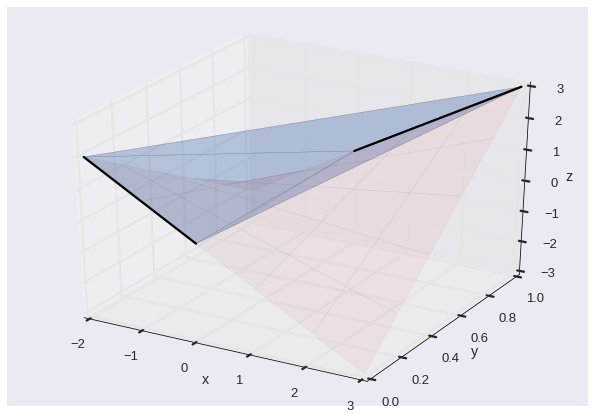

In [29]:
# compute the vertices of the McCormick relaxation
v = poly.sparse2verts(mc + [rlt1, rlt2, rlt3, rlt4], [x, y, z])

# plot the convex hull of the vertices (= the McCormick relaxation) (blue)
fig, ax = poly.plot3d(poly.polygon3D(v));

# plot the actual (continuous) feasible region of z = x*(2*y - 1) (red)
ax.plot_surface(xx, yy, zz, color='r', alpha=0.05)

# plot the two branches of the disjunction for z = abs(x) (black)
ax.plot([0, xlb], [0, 0], [0, abs(xlb)], color='black')
ax.plot([0, xub], [1, 1], [0, abs(xub)], color='black')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');